# Ori/Ter Detection in Escherichia coli K-12 MG1655

**Project for "Introduction to Bioinformatics" course**  
Instructor: Dr. Ali Sharifi Zarchi  

**Author:** Alireza Lashkarbolooki  
**M.Sc. Bioinformatics, Sharif University of Technology**

**Date:** October 20, 2025


This notebook detects the origin of replication (Ori) and terminus (Ter) positions in the **E. coli K-12 MG1655 genome** using multiple indicators:

- GC skew
- Cumulative GC skew
- AT skew
- Cumulative AT skew
- G/C densities
- G/C and GC/AT ratios

We also compare predicted positions to the reference genome positions.

The genome sequence can be accessed at NCBI:

[Escherichia coli K-12 MG1655, complete genome (NC_000913.3)](https://www.ncbi.nlm.nih.gov/nuccore/556503834)


# Import required libraries


In [1]:
import matplotlib.pyplot as plt
from Bio import SeqIO
import numpy as np
import pandas as pd

# Compute GC/AT Features

We slide a window along the genome and calculate several indicators used for Ori/Ter detection.

---

## 1. GC Skew

GC skew in a window is defined as:

$$
\text{GC Skew} = \frac{G - C}{G + C}
$$

where \(G\) and \(C\) are the counts of guanine and cytosine in the window.

Cumulative GC skew is:

$$
\text{Cumulative GC Skew}_i = \sum_{j=1}^{i} \text{GC Skew}_j
$$

---

## 2. AT Skew

AT skew is defined as:

$$
\text{AT Skew} = \frac{A - T}{A + T}
$$

Cumulative AT skew:

$$
\text{Cumulative AT Skew}_i = \sum_{j=1}^{i} \text{AT Skew}_j
$$

---

## 3. Nucleotide Densities

$$
\text{G Density} = \frac{G}{\text{window size}}, \quad
\text{C Density} = \frac{C}{\text{window size}}
$$

---

## 4. Ratios

- G/C ratio:

$$
\text{G/C Ratio} = \frac{G}{C}
$$

- (G+C)/(A+T) ratio:

$$
\text{GC/AT Ratio} = \frac{G + C}{A + T}
$$

---

## 5. Window Position

The center position of the window:

$$
\text{Position} = i + \frac{\text{window size}}{2}
$$

In [3]:
def compute_gc_features(sequence, window_size, step_size):
    seq = sequence.upper()
    gc_skew, sum_gc_skew = [], []
    at_skew, sum_at_skew = [], []
    c_density, g_density = [], []
    gc_ratio, gc_at_ratio = [], []
    positions = []

    sum_gc, sum_at = 0, 0

    for i in range(0, len(seq) - window_size + 1, step_size):
        window = seq[i:i + window_size]
        g = window.count('G')
        c = window.count('C')
        a = window.count('A')
        t = window.count('T')

        # GC skew and cumulative
        skew_gc = (g - c) / (g + c + 1e-8)
        sum_gc += skew_gc
        gc_skew.append(skew_gc)
        sum_gc_skew.append(sum_gc)

        # AT skew and cumulative
        skew_at = (a - t) / (a + t + 1e-8)
        sum_at += skew_at
        at_skew.append(skew_at)
        sum_at_skew.append(sum_at)

        # Densities and ratios
        g_density.append(g / window_size)
        c_density.append(c / window_size)
        gc_ratio.append(g / (c + 1e-8))
        gc_at_ratio.append((g + c) / (a + t + 1e-8))

        # Position
        positions.append(i + window_size // 2)

    return positions, gc_skew, sum_gc_skew, at_skew, sum_at_skew, g_density, c_density, gc_ratio, gc_at_ratio


## Step 2: Load the genome sequence

We load the genome from a FASTA file using Biopython's `SeqIO`.


In [5]:
record = SeqIO.read("sequence.fasta", "fasta")
sequence = str(record.seq)

## Step 3: Compute all GC/AT features

We use a window of 5000 bp and step size of 500 bp for higher resolution analysis.


In [7]:
positions, gc_skew, sum_gc_skew, at_skew, sum_at_skew, g_density, c_density, gc_ratio, gc_at_ratio = compute_gc_features(
    sequence, window_size=5000, step_size=200
)

## Step 4: Define functions to detect Ori/Ter positions

- `annotate_ori_ter`: plots vertical lines and labels for Ori/Ter on a plot
- `find_ori_ter`: returns positions of Ori/Ter based on minimum/maximum of indicator


In [9]:
def annotate_ori_ter(ax, positions, data):
    ori_pos = positions[np.argmin(data)]
    ter_pos = positions[np.argmax(data)]

    #if ori_pos > ter_pos:
    #    ori_pos, ter_pos = ter_pos, ori_pos

    ax.axvline(ori_pos, color='red', linestyle='--', lw=1.2)
    ax.axvline(ter_pos, color='purple', linestyle='--', lw=1.2)
    ax.text(ori_pos, ax.get_ylim()[1]*0.9, f"Ori ({ori_pos//1000} kb)",
            color='red', fontsize=9, ha='center', fontweight='bold')
    ax.text(ter_pos, ax.get_ylim()[1]*0.85, f"Ter ({ter_pos//1000} kb)",
            color='purple', fontsize=9, ha='center', fontweight='bold')


def find_ori_ter(positions, data):
    ori_pos = positions[np.argmin(data)]
    ter_pos = positions[np.argmax(data)]
    #if ori_pos > ter_pos:
    #    ori_pos, ter_pos = ter_pos, ori_pos
    return ori_pos, ter_pos


## Step 5: Plot all indicators with Ori/Ter annotation


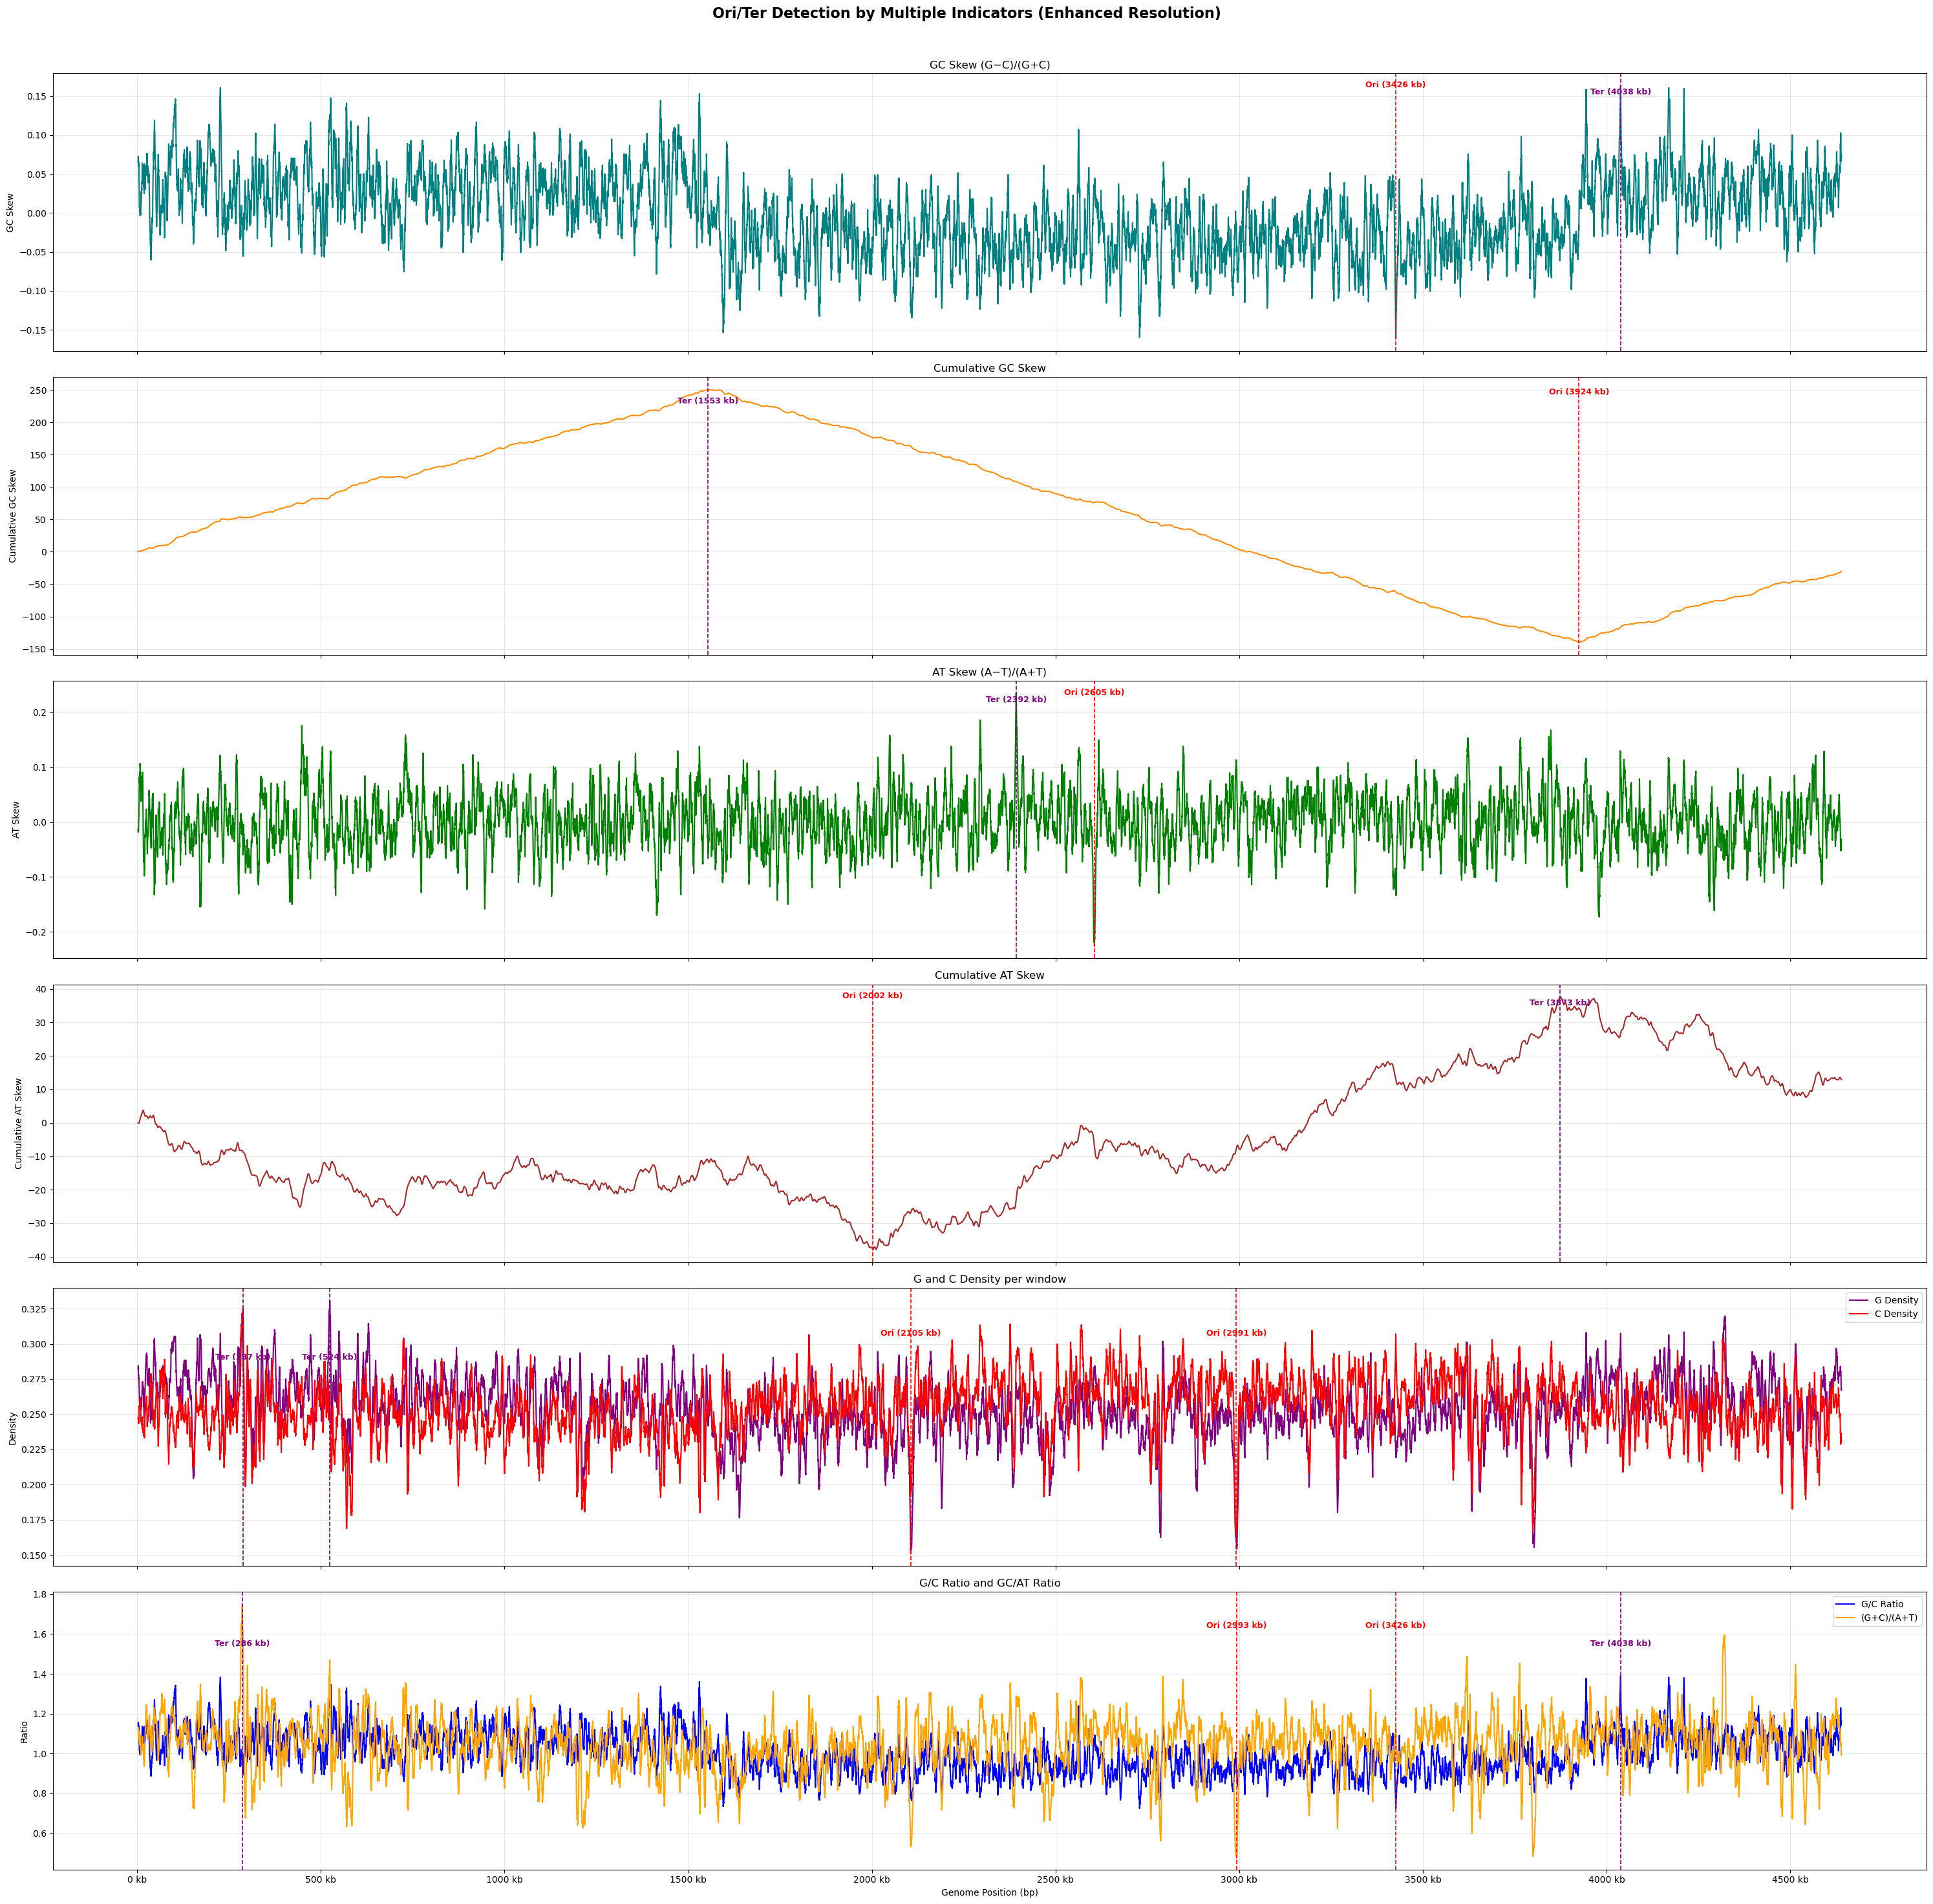

In [11]:
fig, axs = plt.subplots(6, 1, figsize=(30, 30), sharex=True)
fig.suptitle("Ori/Ter Detection by Multiple Indicators (Enhanced Resolution)", fontsize=16, fontweight='bold')


# 1. GC skew
axs[0].plot(positions, gc_skew, color='teal')
axs[0].set_ylabel("GC Skew")
axs[0].set_title("GC Skew (G−C)/(G+C)")
annotate_ori_ter(axs[0], positions, gc_skew)

# 2. Cumulative GC skew
axs[1].plot(positions, sum_gc_skew, color='darkorange')
axs[1].set_ylabel("Cumulative GC Skew")
axs[1].set_title("Cumulative GC Skew")
annotate_ori_ter(axs[1], positions, sum_gc_skew)

# 3. AT skew
axs[2].plot(positions, at_skew, color='green')
axs[2].set_ylabel("AT Skew")
axs[2].set_title("AT Skew (A−T)/(A+T)")
annotate_ori_ter(axs[2], positions, at_skew)

# 4. Cumulative AT skew
axs[3].plot(positions, sum_at_skew, color='brown')
axs[3].set_ylabel("Cumulative AT Skew")
axs[3].set_title("Cumulative AT Skew")
annotate_ori_ter(axs[3], positions, sum_at_skew)

# 5. G/C density
axs[4].plot(positions, g_density, color='purple', label='G Density')
axs[4].plot(positions, c_density, color='red', label='C Density')
axs[4].set_ylabel("Density")
axs[4].set_title("G and C Density per window")
annotate_ori_ter(axs[4], positions, g_density)
annotate_ori_ter(axs[4], positions, c_density)
axs[4].legend()

# 6. Ratios
axs[5].plot(positions, gc_ratio, color='blue', label='G/C Ratio')
axs[5].plot(positions, gc_at_ratio, color='orange', label='(G+C)/(A+T)')
axs[5].set_ylabel("Ratio")
axs[5].set_xlabel("Genome Position (bp)")
axs[5].set_title("G/C Ratio and GC/AT Ratio")
annotate_ori_ter(axs[5], positions, gc_ratio)
annotate_ori_ter(axs[5], positions, gc_at_ratio)
axs[5].legend()

axs[-1].set_xticks(np.arange(0, len(sequence)+1, 500000))
axs[-1].set_xticklabels([f"{x//1000} kb" for x in range(0, len(sequence)+1, 500000)])
for ax in axs:
    ax.grid(alpha=0.3)

plt.tight_layout(rect=[0,0,1,0.97])
plt.show()


## Step 6: Compare Predicted Ori/Ter with Reference Positions

In this step, we compare the predicted Ori and Ter positions from our analysis with **reference genome positions**.

- **`real_ori_start` and `real_ori_end`**: reference oriC region  
- **`real_ter`**: reference terC  

We also calculate **circular distances** between predicted and reference positions, and mark reliability.

The reference origin (oriC) is available at EcoCyc:  

[oriC site in E. coli K-12 MG1655 (EcoCyc)](https://ecocyc.org/ECOLI/NEW-IMAGE?type=EXTRAGENIC-SITE&object=G0-10506)


In [13]:
import pandas as pd

ori_ter_dict = {
    "GC Skew": find_ori_ter(positions, gc_skew),
    "Cumulative GC Skew": find_ori_ter(positions, sum_gc_skew),
    "AT Skew": find_ori_ter(positions, at_skew),
    "Cumulative AT Skew": find_ori_ter(positions, sum_at_skew),
    "G Density": find_ori_ter(positions, g_density),
    "C Density": find_ori_ter(positions, c_density),
    "G/C Ratio": find_ori_ter(positions, gc_ratio),
    "(G+C)/(A+T) Ratio": find_ori_ter(positions, gc_at_ratio),
}

df = pd.DataFrame(ori_ter_dict, index=["Ori (bp)", "Ter (bp)"]).T

real_ori_start, real_ori_end = 3925744, 3925975
real_ori_center = (real_ori_start + real_ori_end) / 2
real_ter = 3925975 

genome_len = len(sequence)

def circular_distance(pos1, pos2, genome_len):
    d = abs(pos1 - pos2)
    return min(d, genome_len - d)

df["Δ Ori_actual (bp)"] = df["Ori (bp)"].apply(lambda x: circular_distance(x, real_ori_center, genome_len))

df["Δ Ter_actual (bp)"] = df["Ter (bp)"].apply(lambda x: circular_distance(x, real_ter, genome_len))

#tolerance = genome_len * 0.05
df["Ori Reliable?"] = df["Δ Ori_actual (bp)"].apply(lambda x: "✅" if x <= 500000 else "❌")
df["Ter Reliable?"] = df["Δ Ter_actual (bp)"].apply(lambda x: "✅" if x <= 500000 else "❌")


df["Δ total"] = df["Δ Ori_actual (bp)"] + df["Δ Ter_actual (bp)"]
df = df.sort_values(by="Δ total")


print("\nOri/Ter Positions with Exact Real Reference Checks:\n")
display(df.style.format({
    "Ori (bp)": "{:,.0f}",
    "Ter (bp)": "{:,.0f}",
    "Δ Ori_actual (bp)": "{:,.0f}",
    "Δ Ter_actual (bp)": "{:,.0f}",
    "Δ Ori→Ter_actual (bp)": "{:,.0f}"
}))

print(f"\n→ Reference oriC Position: [{real_ori_start} → {real_ori_end}] ")
print(f"→ Reference terC Position: {real_ter}")
print(f"→ Genome length: {genome_len} bp")



Ori/Ter Positions with Exact Real Reference Checks:



,Ori (bp),Ter (bp),Δ Ori_actual (bp),Δ Ter_actual (bp),Ori Reliable?,Ter Reliable?,Δ total
GC Skew,"3,426,300","4,038,100","499,560","112,125",✅,✅,611684.500000
G/C Ratio,"3,426,300","4,038,100","499,560","112,125",✅,✅,611684.500000
(G+C)/(A+T) Ratio,"2,993,500","286,100","932,360","1,001,777",❌,❌,1934136.500000
C Density,"2,991,900","287,900","933,960","1,003,577",❌,❌,1937536.500000
Cumulative AT Skew,"2,002,500","3,873,700","1,923,360","52,275",❌,✅,1975634.500000
Cumulative GC Skew,"3,924,700","1,553,100","1,160","2,268,777",✅,❌,2269936.500000
AT Skew,"2,605,900","2,392,500","1,319,960","1,533,475",❌,❌,2853434.500000
G Density,"2,105,900","524,500","1,819,960","1,240,177",❌,❌,3060136.500000



→ Reference oriC Position: [3925744 → 3925975] 
→ Reference terC Position: 3925975
→ Genome length: 4641652 bp
